In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob

from tqdm import tqdm

import itertools
import numpy as np

import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier

from scipy.ndimage import label
import os
from datetime import datetime
from matplotlib import gridspec

In [ ]:
x_columns = ['land_cover',
       'dem', 't2m', 'd2m', 'u10',
       'v10', 'tp','swvl1', 'sp',
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
y_column = 'burn'

In [ ]:
final_df = pd.read_parquet("Training_data/training_whole.parquet")

In [ ]:
X = final_df[x_columns]
y = final_df[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)

In [ ]:
final_df.columns

Index(['lon', 'lat', 'land_cover', 'burn', 'dem', 't2m', 'd2m', 'u10', 'v10',
       'tp', 'swvl1', 'sp', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'band_0', 'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6',
       'band_7', 'band_8', 'band_9', 'band_10', 'band_11', 'band_12',
       'band_13', 'band_14', 'band_15', 'band_16', 'band_17', 'band_18',
       'band_19', 'band_20', 'band_21', 'band_22', 'band_23', 'band_24',
       'band_25', 'band_26', 'band_27', 'band_28', 'band_29', 'band_30',
       'band_31', 'band_32', 'band_33', 'band_34', 'band_35', 'band_36',
       'band_37', 'band_38', 'band_39', 'band_40', 'band_41', 'band_42',
       'band_43', 'band_44', 'band_45', 'band_46', 'band_47', 'band_48',
       'band_49', 'band_50', 'band_51', 'band_52', 'band_53', 'band_54',
       'band_55', 'band_56', 'band_57', 'band_58', 'band_59', 'band_60',
       'band_61', 'band_62', 'band_63', 'embed_mean', 'embed_min', 'embed_max',
       'embed_std'],
      dtype='obje

# Classification - Random Forest

In [ ]:
model_fname = "models/random_forest_model_with_burn.pkl"

if os.path.exists(model_fname):
    model = joblib.load(model_fname)
else:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=20,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )

    model.fit(X_train, y_train)

    joblib.dump(model, model_fname)

166 3952
Accuracy: 0.9989008131306945
Precision: 0.054402834008097166
Recall: 0.09303331890956296
F1 Score: 0.06865719303847996


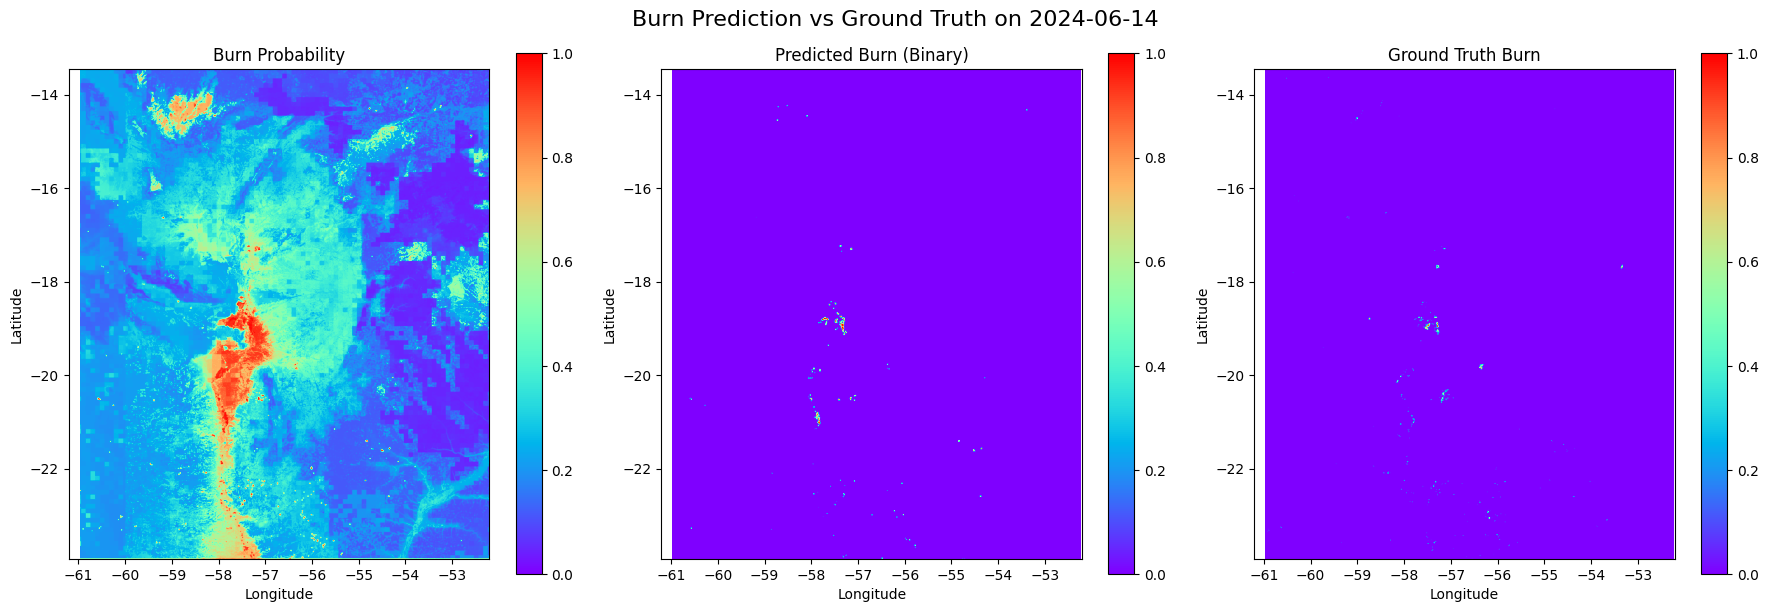

167 8367
Accuracy: 0.998309102729594
Precision: 0.057726783793474366
Recall: 0.30725190839694655
F1 Score: 0.09719287654693633


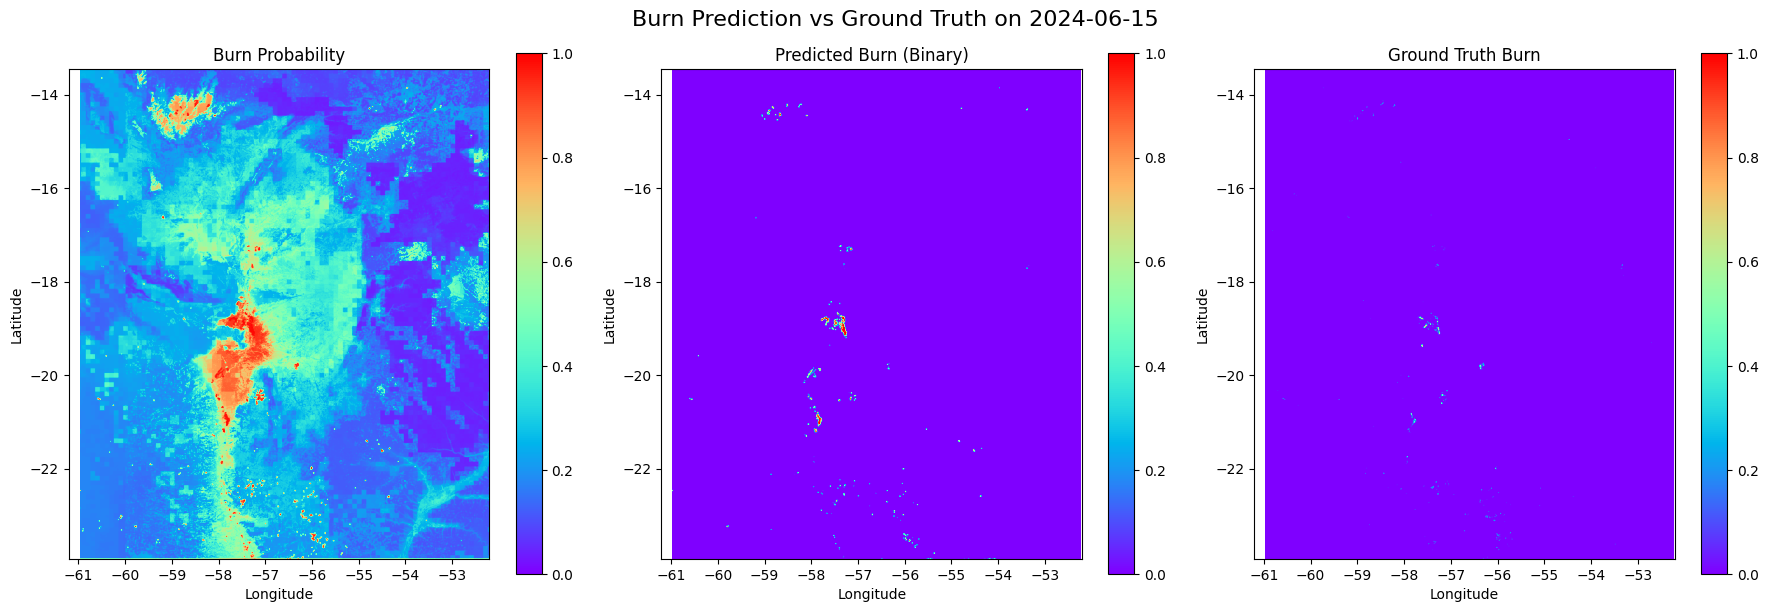

168 8029
Accuracy: 0.9984153844704287
Precision: 0.054303151077344625
Recall: 0.34824281150159747
F1 Score: 0.09395539273785153


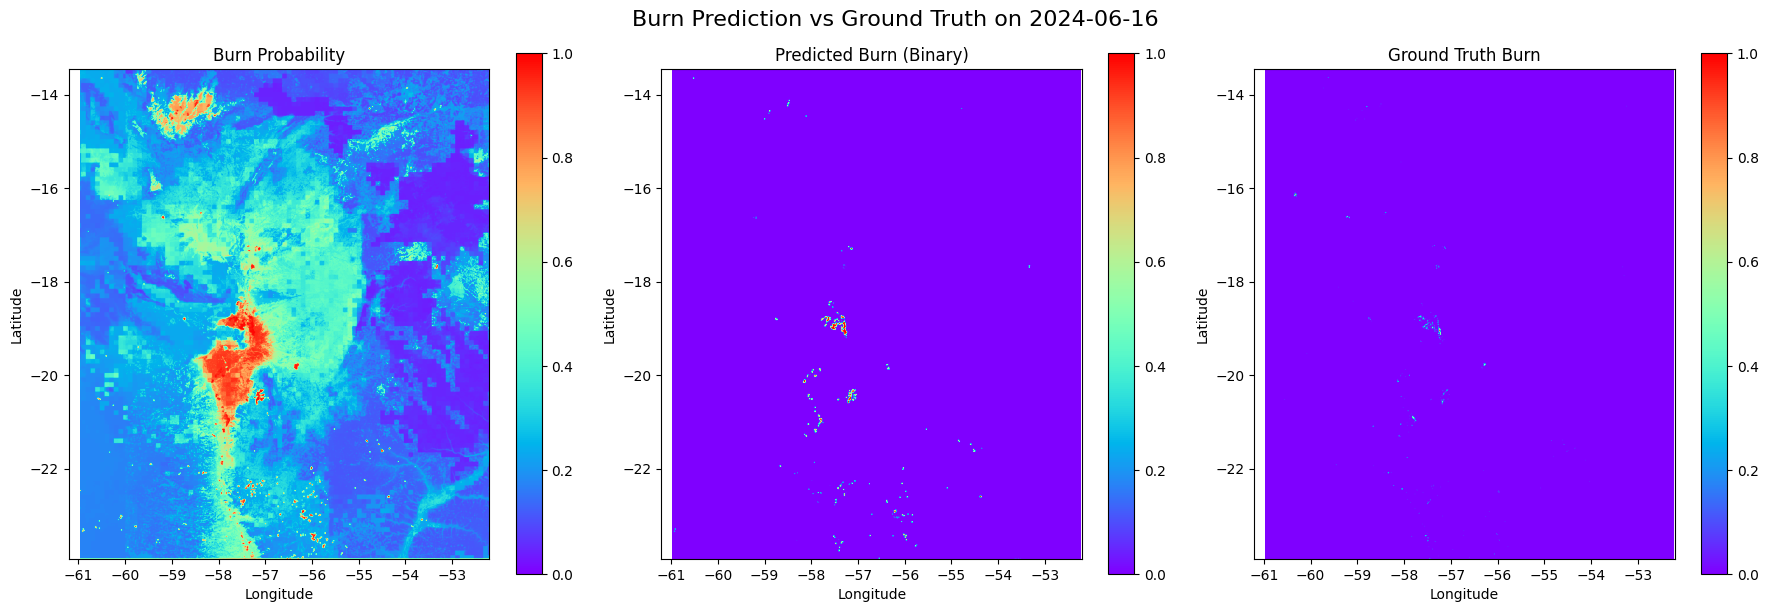

169 6861
Accuracy: 0.9985158244843734
Precision: 0.026963999416994608
Recall: 0.13357400722021662
F1 Score: 0.04487024011642008


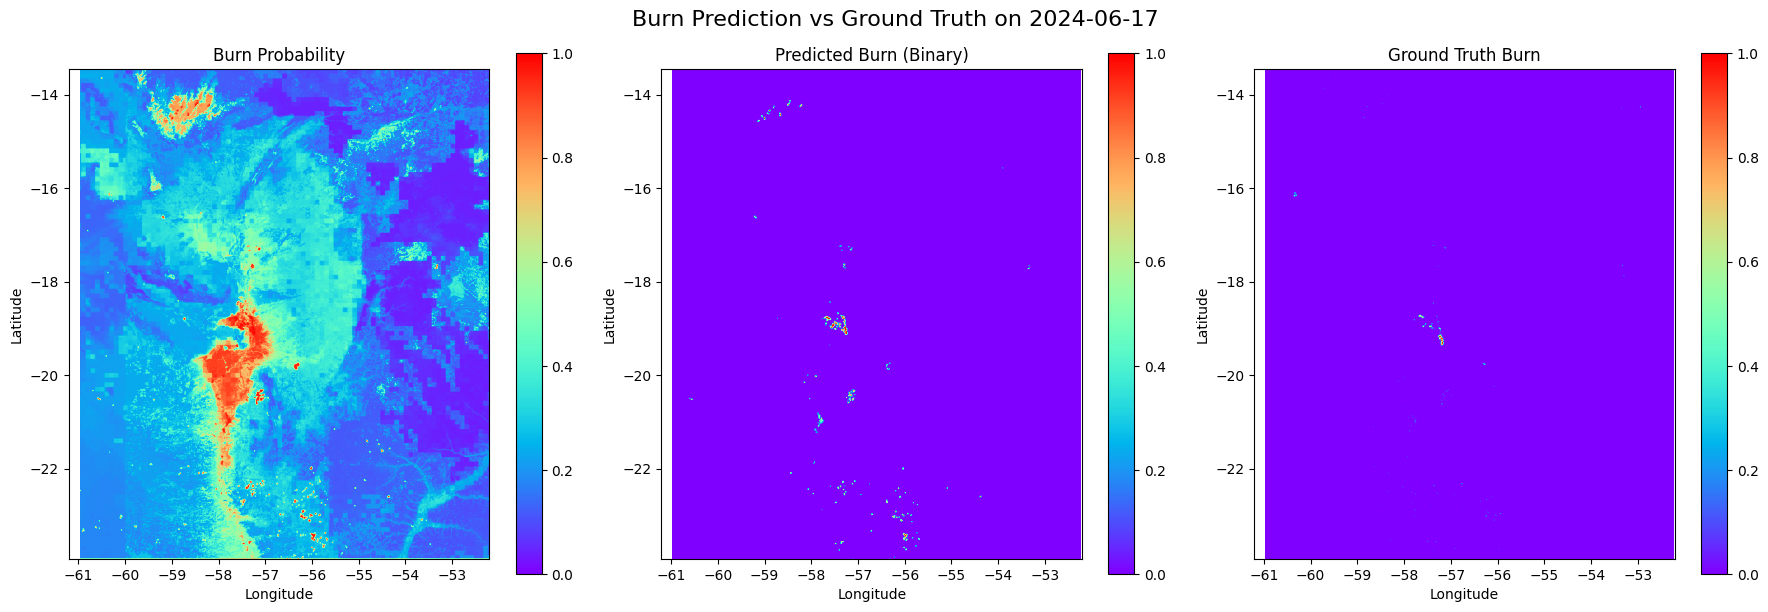

170 5899
Accuracy: 0.9987300839512687
Precision: 0.06390913714188845
Recall: 0.23651191969887075
F1 Score: 0.10062725210196181


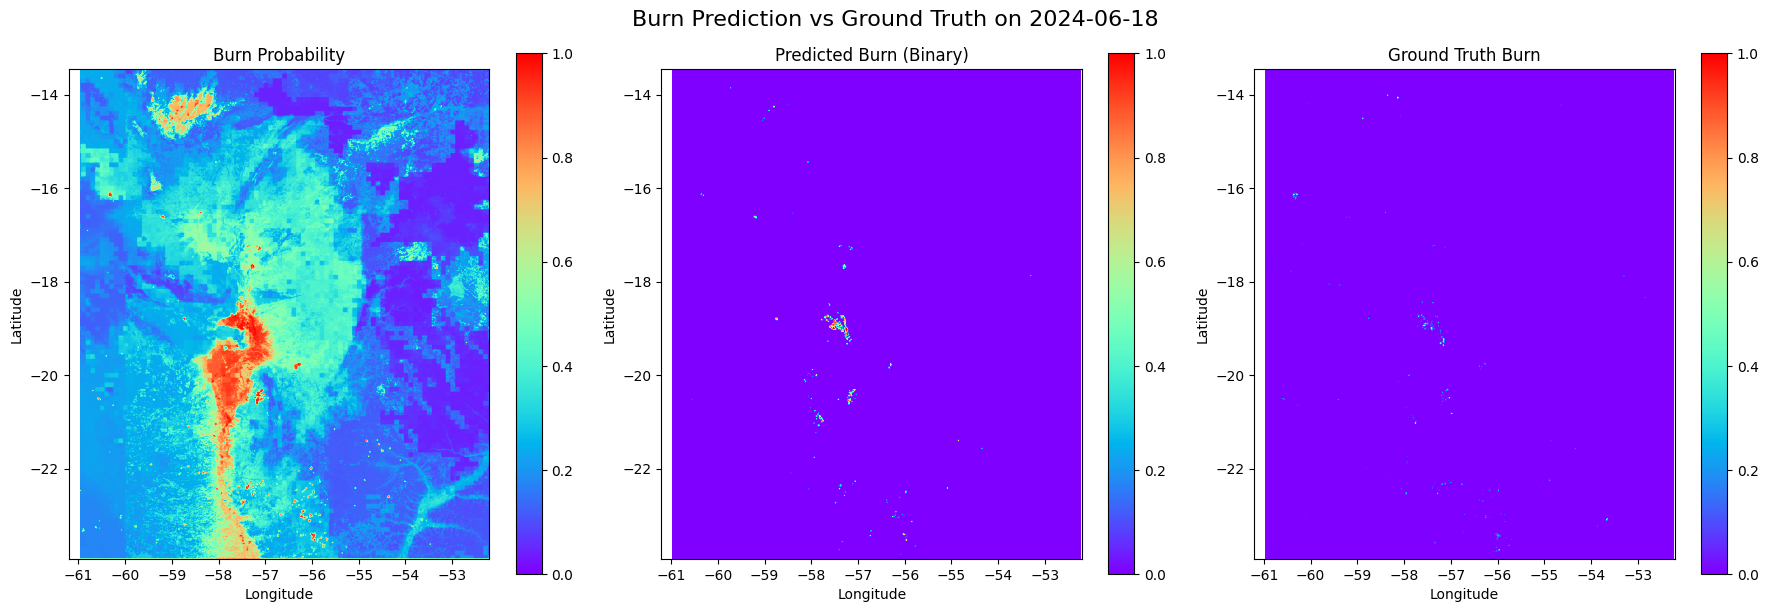

In [ ]:
for doy in range(166,171):

    target_file = f"Testing_data/data_{doy}.parquet"
    target_date = datetime.strptime(f"{2024}-{doy}", "%Y-%j").date()

    # Read one day's data
    df_full  = pd.read_parquet(target_file)
    df_pred = df_full.dropna(subset=x_columns + [y_column])

    X_pred = df_pred[x_columns]
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > 0.975).astype(int)

    print(doy, np.sum(y_pred))

    if np.sum(y_pred) > 5:

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]

        extent = [lons.min(), lons.max(), lats.min(), lats.max()]

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        im0 = axes[0].imshow(burn_prob_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[0].set_title("Burn Probability")
        axes[0].set_xlabel("Longitude")
        axes[0].set_ylabel("Latitude")
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(burn_pred_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[1].set_title("Predicted Burn (Binary)")
        axes[1].set_xlabel("Longitude")
        axes[1].set_ylabel("Latitude")
        plt.colorbar(im1, ax=axes[1])

        im2 = axes[2].imshow(burn_true_image, origin='lower', cmap='rainbow', vmin=0, vmax=1, extent=extent)
        axes[2].set_title("Ground Truth Burn")
        axes[2].set_xlabel("Longitude")
        axes[2].set_ylabel("Latitude")
        plt.colorbar(im2, ax=axes[2])

        plt.suptitle(f"Burn Prediction vs Ground Truth on {target_date}", fontsize=16)
        plt.tight_layout()
        plt.show()

166 3952
Accuracy: 0.9989008131306945
Precision: 0.054402834008097166
Recall: 0.09303331890956296
F1 Score: 0.06865719303847996


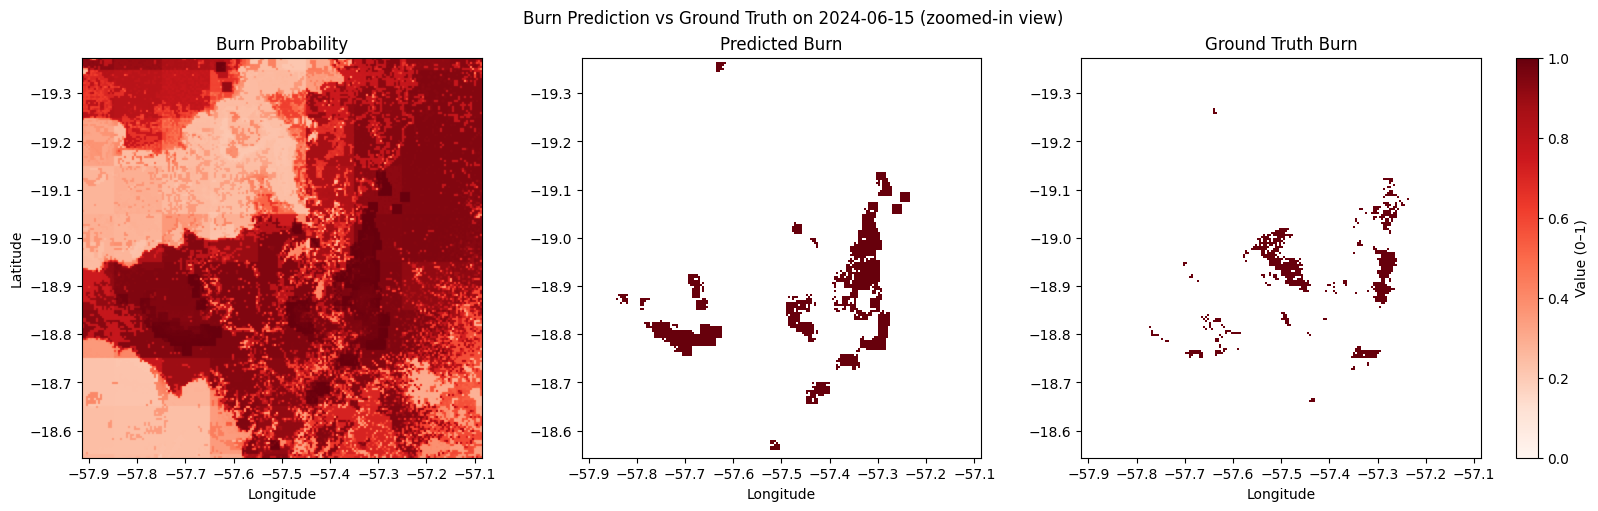

167 8367
Accuracy: 0.998309102729594
Precision: 0.057726783793474366
Recall: 0.30725190839694655
F1 Score: 0.09719287654693633


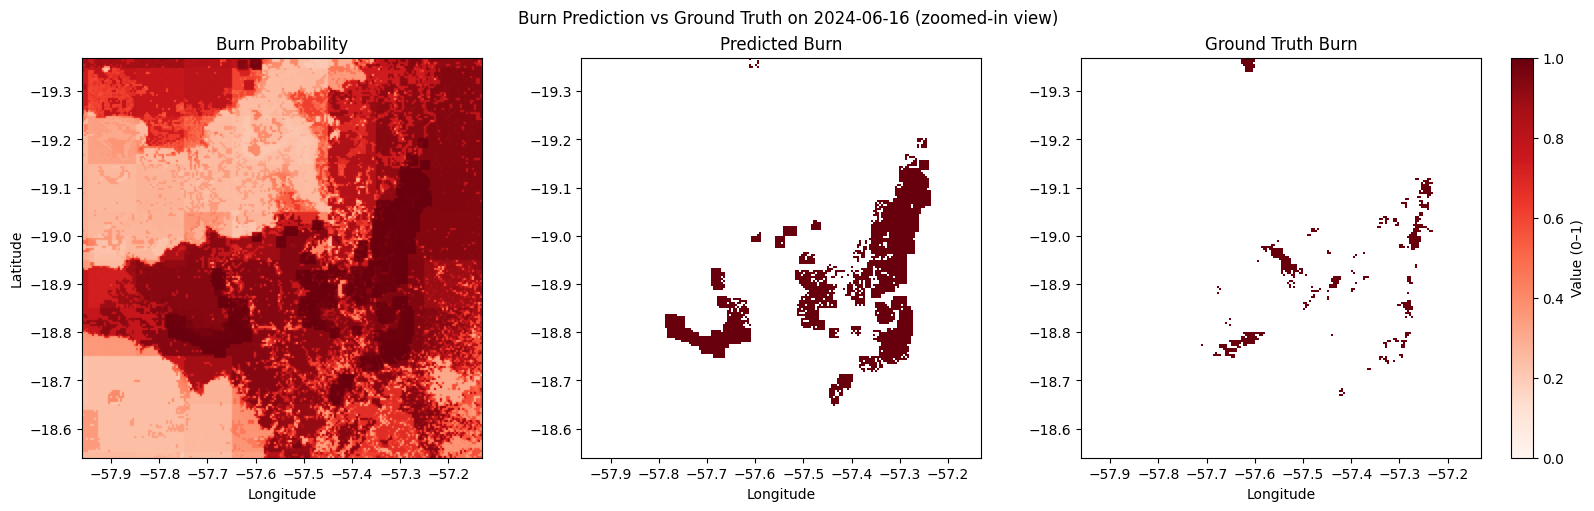

168 8029
Accuracy: 0.9984153844704287
Precision: 0.054303151077344625
Recall: 0.34824281150159747
F1 Score: 0.09395539273785153


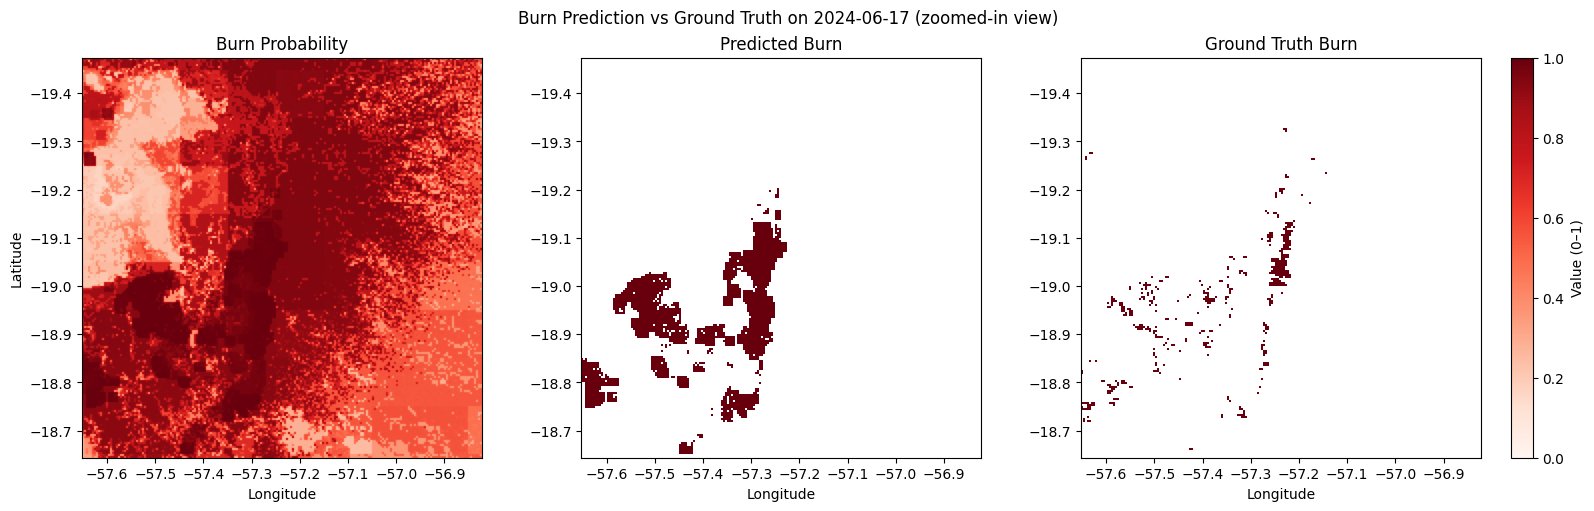

169 6861
Accuracy: 0.9985158244843734
Precision: 0.026963999416994608
Recall: 0.13357400722021662
F1 Score: 0.04487024011642008


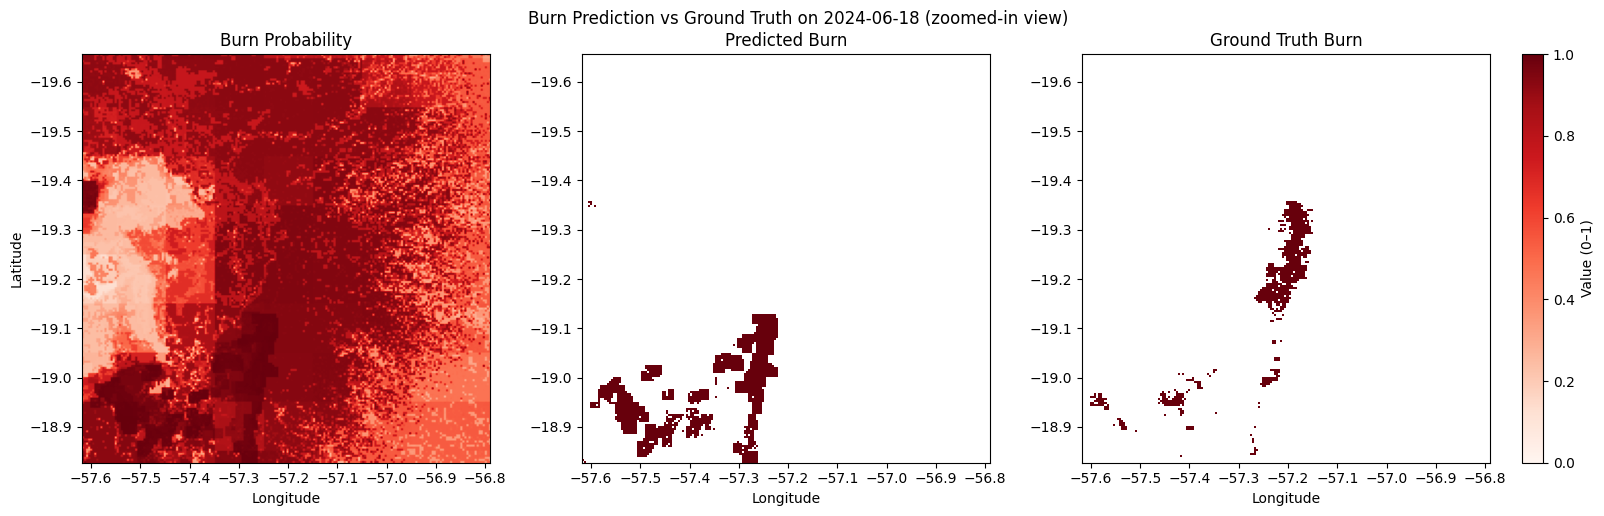

170 5899
Accuracy: 0.9987300839512687
Precision: 0.06390913714188845
Recall: 0.23651191969887075
F1 Score: 0.10062725210196181


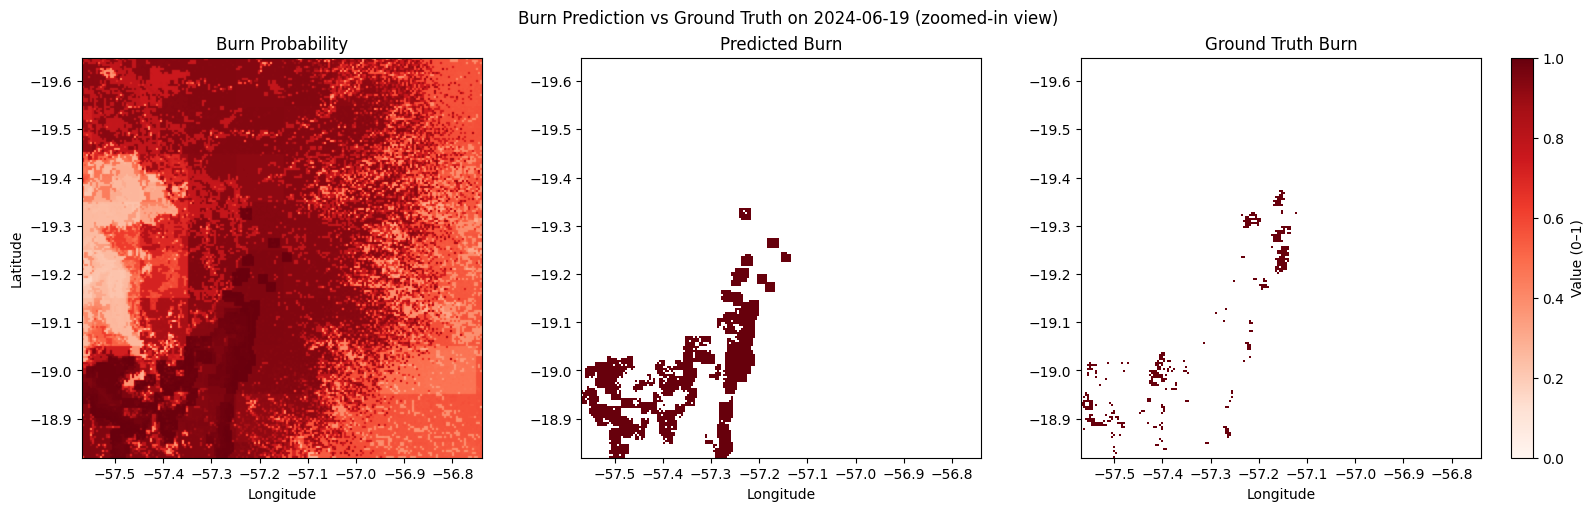

In [ ]:
prob_threshold = 0.975

for doy in range(166,171):

    target_file = f"/yu/s1/I-GUIDE summer school/data/Training/Daily/data_{doy}.parquet"
    target_date = datetime.strptime(f"{2024}-{doy+1}", "%Y-%j").date()

    # Read one day's data
    df_full  = pd.read_parquet(target_file)
    df_pred = df_full.dropna(subset=x_columns + [y_column])

    X_pred = df_pred[x_columns]
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)

    print(doy, np.sum(y_pred))

    if np.sum(y_pred) > 5:

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]

        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]

        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        reds = plt.colormaps['Reds'].copy()
        reds.set_bad(color='white')

        # Predicted burn
        burn_pred_crop[burn_pred_crop == 0] = np.nan
        im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        burn_true_crop[burn_true_crop == 0] = np.nan
        im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")

        fig.suptitle(f"Burn Prediction vs Ground Truth on {target_date} (zoomed-in view)")
        plt.show()

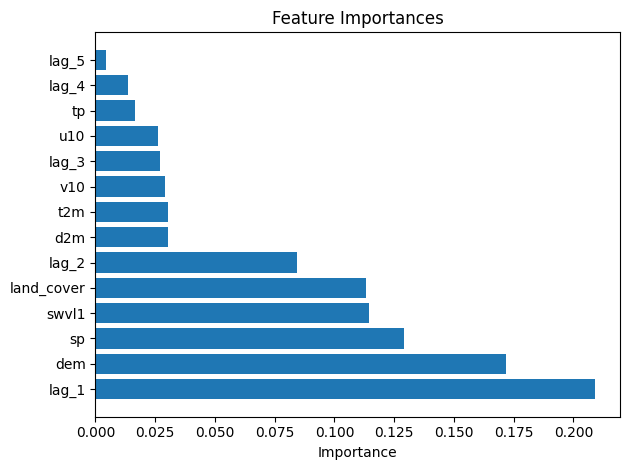

In [ ]:
# Compute feature importances
feature_importances = pd.Series(
    model.feature_importances_,
    index=x_columns
).sort_values(ascending=True)  # ascending=True for better horizontal plot

plt.figure()
plt.barh(feature_importances.index, feature_importances.values)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

Precision: 0.888199083627715
Recall   : 0.8303062008533735
F1 Score : 0.8582774965990994


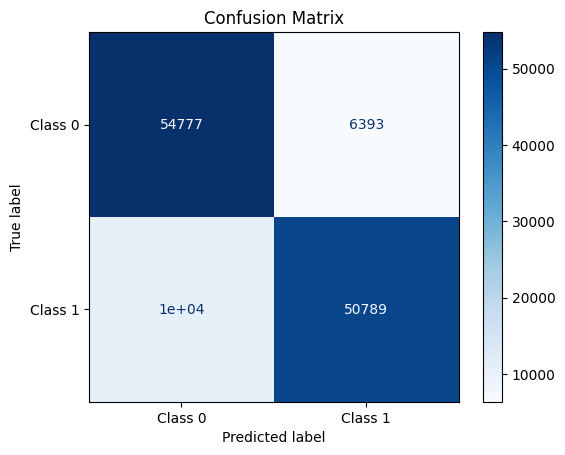

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()